<a href="https://colab.research.google.com/github/mMitsu0/tcc_dengue_final/blob/main/dengue_previs_o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CENTRO UNIVERSITÁRIO NOSSA SENHORA DO PATROCÍNIO (CEUNSP)**
SALTO - SP

**BARACHELADO EM CIÊNCIA DA COMPUTAÇÕES**

# ***Análise Comparativa de Algoritmos de Machine Learning para Predição de Casos de Dengue.***

Autores:
*Matheus Mitsuo Tomotake Santos - RGM: 30248531*
*Pedro Gavioli Pinarde - RGM: 25798006*
*Lucas Felix Nogueira -RGM: 28851994*
*Gabriel Souza Cavalcante: RGM - 30386730*

**IMPORT DAS BIBLIOTECAS NECESSÁRIAS**

In [46]:
# === Utilidades do sistema e dados ===
import os  # Interações com o sistema operacional (ex: manipulação de arquivos e diretórios)
import pandas as pd  # Manipulação e análise de dados em tabelas (DataFrames)
import numpy as np  # Operações matemáticas e numéricas eficientes com arrays

# === Visualização de dados ===
import matplotlib.pyplot as plt  # Criação de gráficos e visualizações personalizadas
import seaborn as sns  # Visualizações estatísticas com design aprimorado

# === Requisições e manipulação de arquivos ===
import requests  # Requisições HTTP para acessar APIs e baixar dados
from io import StringIO  # Permite tratar strings como arquivos (útil para ler CSVs diretamente da web)

# === Machine Learning Clássico ===
from sklearn.model_selection import train_test_split  # Divisão dos dados em conjuntos de treino e teste
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Modelos baseados em árvores de decisão
from sklearn.linear_model import LinearRegression  # Modelo de regressão linear tradicional
from xgboost import XGBRegressor  # Modelo de regressão baseado em boosting com alta performance
from sklearn.metrics import mean_squared_error, r2_score  # Métricas de avaliação (MSE e R²)
from sklearn.preprocessing import StandardScaler  # Normalização e padronização de variáveis (features)

# === Deep Learning (LSTM) ===
import tensorflow as tf  # Biblioteca de aprendizado profundo
from tensorflow.keras import layers, models, callbacks, optimizers  # Componentes do Keras para redes neurais LSTM

# === Configuração de ambiente (para Jupyter) ===
try:
    get_ipython().run_line_magic("matplotlib", "inline")  # Exibe gráficos diretamente no notebook
except:
    pass  # Ignora se não estiver em ambiente Jupyter


**CONEXÃO COM A API E DOWNLOAD DOS DADOS**

In [ ]:
# === IMPORTS ===
import os  # Interações com o sistema operacional (ex: criar pastas)
import requests  # Requisições HTTP (para baixar dados da API InfoDengue)
import pandas as pd  # Manipulação e análise de dados tabulares
from io import StringIO  # Permite tratar strings como arquivos (útil para ler CSV direto da API)
from datetime import datetime  # Controle de datas (para definir ano atual automaticamente)

# ===============================================================
# === 1. DOWNLOAD DOS DADOS ===
# ===============================================================

# Dicionário com códigos IBGE das capitais brasileiras (usados na API InfoDengue)
estados_ibge = {
    "AC": [1200401], "AL": [2704302], "AM": [1302603], "AP": [1600303],
    "BA": [2927408], "CE": [2304400], "DF": [5300108], "ES": [3205309],
    "GO": [5208707], "MA": [2111300], "MG": [3106200], "MS": [5002704],
    "MT": [5103403], "PA": [1501402], "PB": [2507507], "PE": [2611606],
    "PI": [2211001], "PR": [4106902], "RJ": [3304557], "RN": [2408102],
    "RO": [1100205], "RR": [1400100], "RS": [4314902], "SC": [4205407],
    "SE": [2800308], "SP": [3550308], "TO": [1721000]
}

def baixar_dados_por_estado(diretorio_saida="data/raw", ano_inicio=2001, ano_fim=None):
    """
    Função responsável por baixar dados de dengue do InfoDengue
    para todas as capitais brasileiras, entre anos definidos.

    Parâmetros:
    - diretorio_saida (str): caminho onde o CSV final será salvo.
    - ano_inicio (int): primeiro ano da série temporal a ser coletada.
    - ano_fim (int | None): último ano da série; se None, usa o ano atual.
    """

    # Cria a pasta de destino caso não exista
    os.makedirs(diretorio_saida, exist_ok=True)

    # URL base da API InfoDengue
    base_url = "https://info.dengue.mat.br/api/alertcity"

    # Lista para armazenar os DataFrames de cada estado
    dfs = []

    # Define o ano final como o ano atual caso não seja informado
    if ano_fim is None:
        ano_fim = datetime.now().year

    # Loop sobre todos os estados e seus respectivos códigos IBGE
    for estado, municipios in estados_ibge.items():
        for geocode in municipios:

            # Monta os parâmetros da requisição
            params = {
                "geocode": geocode,
                "disease": "dengue",
                "format": "csv",
                "ew_start": 1,
                "ew_end": 52,
                "ey_start": ano_inicio,
                "ey_end": ano_fim
            }

            # Constrói a URL final da requisição
            url = f"{base_url}?{'&'.join([f'{k}={v}' for k,v in params.items()])}"

            try:
                # Envia requisição HTTP
                response = requests.get(url)

                # Verifica se a resposta foi bem-sucedida
                if response.status_code == 200:
                    # Lê o conteúdo CSV direto da resposta e cria um DataFrame
                    df = pd.read_csv(StringIO(response.text))
                    df["estado"] = estado
                    df["codigo_ibge"] = geocode
                    dfs.append(df)
                    print(f"✓ Dados coletados para {estado} ({ano_inicio}-{ano_fim})")
                else:
                    print(f" Falha ao coletar {estado} - status {response.status_code}")

            except Exception as e:
                print(f" Erro ao processar {estado}: {e}")

    # Após o loop, junta todos os DataFrames e salva em um único CSV
    if dfs:
        df_final = pd.concat(dfs, ignore_index=True)
        caminho_csv = f"{diretorio_saida}/dengue_{ano_inicio}_{ano_fim}_por_estado.csv"
        df_final.to_csv(caminho_csv, index=False)
        print(f"\n Dados salvos com sucesso em: {caminho_csv}")
    else:
        print(" Nenhum dado foi coletado.")

**REFINAMENTO DOS DADOS / FEATURES**

In [ ]:
# ===============================================================
# === 2. ENGENHARIA DE FEATURES ===
# ===============================================================
# Objetivo: preparar os dados brutos para uso em modelos de Machine Learning.
# As etapas incluem limpeza, criação de variáveis temporais e remoção de outliers.
# ===============================================================

def carregar_e_limpar(caminho_arquivo):
    """
    Carrega o arquivo CSV contendo os dados de dengue e retorna um DataFrame.

    Parâmetros:
    - caminho_arquivo (str): Caminho completo para o arquivo CSV.

    Retorna:
    - df (DataFrame): Dados carregados em formato pandas.
    """
    return pd.read_csv(caminho_arquivo)


def adicionar_variaveis_temporais(df):
    """
    Adiciona colunas temporais e variáveis derivadas ao DataFrame.

    - Converte a coluna 'data_iniSE' para o formato datetime.
    - Cria colunas de ano e semana epidemiológica.
    - Cria variáveis defasadas (lags) de 1, 2 e 3 semanas.
    - Calcula a média móvel de 3 semanas dos casos.

    Parâmetros:
    - df (DataFrame): Dados originais com a coluna 'data_iniSE' e 'casos'.

    Retorna:
    - df (DataFrame): Dados com as novas colunas de engenharia temporal.
    """
    # Conversão da data para formato datetime
    df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])

    # Criação das variáveis temporais
    df['epidemiological_year'] = df['data_iniSE'].dt.year
    df['epidemiological_week'] = df['data_iniSE'].dt.isocalendar().week

    # Criação de variáveis de defasagem (lags)
    df['casos_lag_1'] = df['casos'].shift(1)
    df['casos_lag_2'] = df['casos'].shift(2)
    df['casos_lag_3'] = df['casos'].shift(3)

    # Média móvel dos 3 lags (captura tendência recente)
    df['casos_media_3'] = df[['casos_lag_1', 'casos_lag_2', 'casos_lag_3']].mean(axis=1)

    return df


def remover_outliers(df, features):
    """
    Remove valores extremos (outliers) das variáveis especificadas.

    O método utilizado é baseado no IQR (Interquartile Range),
    removendo valores que estejam fora do intervalo [Q1 - 1.5*IQR, Q3 + 1.5*IQR].

    Parâmetros:
    - df (DataFrame): Conjunto de dados original.
    - features (list): Lista de colunas numéricas para aplicar o filtro.

    Retorna:
    - df (DataFrame): Conjunto de dados sem outliers nas features selecionadas.
    """
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 * IQR)]
    return df


**MODELOS DE PREDIÇÃO**

In [ ]:
# ===============================================================
# === 3.1 MODELOS MACHINE LEARNING (CLÁSSICOS) ===
# ===============================================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def time_weights(ord_vec, power: float = 1.0):
    """
    Gera pesos temporais dando mais peso para semanas mais recentes.

    Parâmetros
    ----------
    ord_vec : array-like
        Vetor temporal no formato YYYYWW (ex: 202450).
    power : float, default=1.0
        Controla o quão agressiva é a ênfase no recente.
        - 0 -> todos iguais
        - 1 -> leve ênfase
        - >1 -> mais peso ainda para recente

    Retorna
    -------
    weights : np.ndarray
        Vetor de pesos positivo, normalizado para média = 1.
    """
    ord_vec = np.asarray(ord_vec, dtype=float)
    if ord_vec.size == 0:
        return np.array([], dtype=float)

    o_min = ord_vec.min()
    o_max = ord_vec.max()

    # evita divisão por zero
    if o_max == o_min:
        weights = np.ones_like(ord_vec)
    else:
        # normaliza para [0,1] (0 = mais antigo, 1 = mais recente)
        norm = (ord_vec - o_min) / (o_max - o_min)
        # transforma em pesos, puxando pra cima (>= 0.5)
        weights = 0.5 + 0.5 * (norm ** power)

    # normaliza para média 1 (ajuda em treinamento estável)
    weights = weights / weights.mean()
    return weights

def treinar_modelos_classicos(
    X: np.ndarray,
    y: np.ndarray,
    test_size: float = 0.2,
    random_state: int = 42
):
    """
    Treina quatro modelos de ML clássico (Linear Regression, Random Forest,
    Gradient Boosting e XGBoost) e retorna métricas de desempenho.

    Parâmetros
    ----------
    X : np.ndarray
        Matriz de features (n_amostras x n_features).
    y : np.ndarray
        Vetor alvo (n_amostras,).
    test_size : float, default=0.2
        Proporção dos dados reservada para teste.
    random_state : int, default=42
        Semente para reprodutibilidade.

    Retorna
    -------
    resultados : dict
        Dicionário {nome_modelo: (mse, rmse, r2, nrmse_pct)}.
    modelos_treinados : dict
        Dicionário {nome_modelo: instancia_treinada}.
    """
    # Split simples (não temporal) — bom como baseline
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Conjunto de modelos base com configurações reprodutíveis
    modelos = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(
            n_estimators=300,
            random_state=random_state,
            n_jobs=-1
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            random_state=random_state
        ),
        "XGBoost": XGBRegressor(
            random_state=random_state,
            n_estimators=600,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            tree_method="hist",   # mais rápido; use "gpu_hist" se houver GPU
        ),
    }

    resultados = {}
    modelos_treinados = {}

    for nome, modelo in modelos.items():
        # XGBoost com early stopping opcional
        if isinstance(modelo, XGBRegressor):
            modelo.fit(
                X_train, y_train,
                eval_set=[(X_test, y_test)],
                verbose=False,
                early_stopping_rounds=50
            )
        else:
            modelo.fit(X_train, y_train)

        # Predição no teste
        y_pred = modelo.predict(X_test)

        # Métricas
        mse = mean_squared_error(y_test, y_pred)
        rmse = float(np.sqrt(mse))
        r2 = r2_score(y_test, y_pred)
        media_y = float(np.mean(y_test))
        nrmse_pct = (rmse / media_y * 100.0) if media_y != 0 else np.nan

        resultados[nome] = (mse, rmse, r2, nrmse_pct)
        modelos_treinados[nome] = modelo

    return resultados, modelos_treinados

    # Treinamento e avaliação padronizados
    for nome, modelo in modelos.items():
        # Para XGBoost podemos usar early stopping de forma segura
        if isinstance(modelo, XGBRegressor):
            modelo.fit(
                X_train, y_train,
                eval_set=[(X_test, y_test)],
                verbose=False,
                early_stopping_rounds=50
            )
        else:
            modelo.fit(X_train, y_train)

        # Predição e métricas
        y_pred = modelo.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = float(np.sqrt(mse))
        r2 = r2_score(y_test, y_pred)
        media_y = float(np.mean(y_test))
        nrmse_pct = (rmse / media_y * 100.0) if media_y != 0 else np.nan

        resultados[nome] = (mse, rmse, r2, nrmse_pct)
        modelos_treinados[nome] = modelo

    return resultados, modelos_treinados


def resultados_para_dataframe(resultados: dict) -> pd.DataFrame:
    """
    Converte o dicionário de métricas em um DataFrame ordenado por RMSE.
    """
    colunas = ["Modelo", "MSE", "RMSE", "R2", "NRMSE_%"]
    linhas = [
        [nome, *metricas] for nome, metricas in resultados.items()
    ]
    df_res = pd.DataFrame(linhas, columns=colunas)
    return df_res.sort_values("RMSE").reset_index(drop=True)


In [ ]:
# ===============================================================
# === 3.2 LSTM — Modelagem Sequencial por Estado (multi-séries) ===
# ===============================================================
# Ideia central:
# 1) Ordenar dados por (estado, ano, semana) e montar janelas (lookback) -> alvo (horizon).
# 2) Separar treino/teste por "cutoff" temporal (ano, semana).
# 3) Escalonar SOMENTE as features (usando apenas treino).
# 4) Treinar LSTM e avaliar com MSE, RMSE, R² e nRMSE (%).
# ===============================================================

import numpy as np
import pandas as pd
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers


def _ord_from_year_week(y, w):
    """
    Gera um número ordenável no formato YYYYWW para facilitar ordenação temporal.
    Ex.: ano=2024, semana=5 -> 202405
    """
    return int(f"{int(y):04d}{int(w):02d}")


def _build_sequences_by_state(df, features, lookback=8, horizon=1):
    """
    Constrói janelas temporais 3D por estado:
    - Para cada estado (codigo_ibge), ordena no tempo e cria pares:
        X[t-lookback:t, features] -> y[t + horizon - 1]
    - Retorna:
        X: shape (n_amostras, lookback, n_features)
        y: shape (n_amostras,)

    Parâmetros:
    - df (DataFrame): deve conter colunas 'codigo_ibge', 'epidemiological_year',
                      'epidemiological_week' e 'casos', além de 'features'.
    - features (list[str]): nomes das colunas de entrada.
    - lookback (int): tamanho da janela temporal usada como entrada.
    - horizon (int): passo à frente a ser previsto (1 = próxima semana).

    Observação:
    - Só cria amostras quando existe histórico suficiente (len >= lookback + horizon).
    """
    X_list, y_list = [], []

    # Ordenação global por estado/tempo para consistência
    df = df.sort_values(["codigo_ibge", "epidemiological_year", "epidemiological_week"]).copy()

    for gid, g in df.groupby("codigo_ibge"):
        g = g.copy()
        # Índice temporal ordenável
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")

        # Arrays de entrada (features) e alvo (casos)
        feats_arr  = g[features].to_numpy(dtype=float)
        target_arr = g["casos"].to_numpy(dtype=float)

        # Pula estados com histórico insuficiente
        if len(g) < lookback + horizon:
            continue

        # Deslizamento temporal para gerar janelas
        for t in range(lookback, len(g) - horizon + 1):
            X_list.append(feats_arr[t - lookback:t])
            y_list.append(target_arr[t + horizon - 1])

    X = np.array(X_list)  # (n_amostras, lookback, n_features)
    y = np.array(y_list)  # (n_amostras,)
    return X, y


def _temporal_mask_by_cutoff(df, lookback, horizon, cutoff=(2020, 1)):
    """
    Gera uma máscara booleana (True para TREINO, False para TESTE) com base em um
    "corte" temporal (ano, semana). Qualquer amostra cujo alvo (y) ocorra em
    ord_target < ord_cut -> TREINO; caso contrário -> TESTE.

    Mantém o MESMO critério de varredura de _build_sequences_by_state para alinhar
    1:1 as posições das amostras em X/y com a máscara retornada.
    """
    ord_cut = _ord_from_year_week(*cutoff)
    mask_list = []

    # Ordena e repete a varredura por estado
    for gid, g in df.sort_values(["codigo_ibge", "epidemiological_year", "epidemiological_week"]).groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")

        if len(g) < lookback + horizon:
            continue

        ord_vec = g["ord"].to_numpy()
        for t in range(lookback, len(g) - horizon + 1):
            ord_target = ord_vec[t + horizon - 1]
            mask_list.append(ord_target < ord_cut)  # True -> treino; False -> teste

    mask = np.array(mask_list, dtype=bool)
    return mask


def treinar_lstm_separado(
    df_feat_sem_outliers: pd.DataFrame,
    features: list,
    lookback: int = 8,
    horizon: int = 1,
    cutoff_test: tuple = (2020, 1),
    epochs: int = 80,
    batch_size: int = 256,
    lr: float = 1e-3,
    verbose: int = 1
):
    """
    Treina uma LSTM em janelas temporais por estado (multi-séries agregadas).

    Parâmetros:
    - df_feat_sem_outliers: DataFrame já limpo/filtrado (sem outliers) contendo:
        ['codigo_ibge','epidemiological_year','epidemiological_week','casos'] + features
    - features: lista de colunas numéricas de entrada.
    - lookback: tamanho da janela temporal (semanas) usada como entrada.
    - horizon: horizonte de previsão em semanas (1 = próxima semana).
    - cutoff_test: (ano, semana) — tudo com alvo >= cutoff vai para TESTE.
    - epochs, batch_size, lr, verbose: hiperparâmetros do treinamento.

    Retorna:
    - resultados_lstm: dict {"LSTM": (mse_te, rmse_te, r2_te, nrmse_te)}
    - model_lstm: modelo Keras treinado.
    - scaler: StandardScaler ajustado sobre as features do TREINO (para reuso em produção).
    """

    # 0) Higiene: garantir numéricos e sem NaN nas features (ffill/bfill conservadora)
    df_seq = df_feat_sem_outliers.copy()
    df_seq[features] = df_seq[features].astype(float).fillna(method="ffill").fillna(method="bfill")
    df_seq["casos"] = df_seq["casos"].astype(float)

    # 1) Construir tensores 3D (amostras, lookback, n_features)
    X_all, y_all = _build_sequences_by_state(df_seq, features, lookback=lookback, horizon=horizon)
    if len(X_all) == 0:
        raise ValueError(
            "Não foi possível construir sequências para a LSTM. "
            "Verifique se há dados suficientes por estado (lookback + horizon)."
        )

    # 2) Máscara temporal alinhada (True = treino; False = teste)
    mask_train = _temporal_mask_by_cutoff(df_seq, lookback, horizon, cutoff=cutoff_test)
    if mask_train.shape[0] != X_all.shape[0]:
        raise RuntimeError(
            "Máscara temporal não alinhada com as sequências. "
            "Garanta que _build_sequences_by_state e _temporal_mask_by_cutoff percorrem os mesmos estados e janelas."
        )

    X_tr, y_tr = X_all[mask_train], y_all[mask_train]
    X_te, y_te = X_all[~mask_train], y_all[~mask_train]

    # 3) Escalonamento (apenas sobre TREINO) — reshape para 2D, ajusta, e volta pro 3D
    n_features = X_tr.shape[-1]
    scaler = StandardScaler()
    X_tr_2d = X_tr.reshape(-1, n_features)
    scaler.fit(X_tr_2d)  # fit apenas com treino

    X_tr_scaled = scaler.transform(X_tr_2d).reshape(X_tr.shape)
    X_te_scaled = scaler.transform(X_te.reshape(-1, n_features)).reshape(X_te.shape)

    # 4) Arquitetura LSTM simples e robusta para séries semanais
    def build_lstm(input_shape, lr=lr):
        inp = layers.Input(shape=input_shape)
        x = layers.LSTM(64, return_sequences=True)(inp)
        x = layers.Dropout(0.2)(x)
        x = layers.LSTM(32)(x)
        x = layers.Dense(16, activation="relu")(x)
        out = layers.Dense(1)(x)
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
        return model

    model_lstm = build_lstm((lookback, n_features), lr=lr)

    # Callbacks: early stopping + ajuste adaptativo da taxa de aprendizado
    early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    plateau = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")

    # 5) Treinamento (validação interna só no treino — teste já foi separado temporalmente)
    hist = model_lstm.fit(
        X_tr_scaled, y_tr,
        validation_split=0.15,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early, plateau],
        verbose=verbose
    )

    # 6) Avaliação em TREINO e TESTE (métricas padrão)
    y_hat_tr = model_lstm.predict(X_tr_scaled, verbose=0).ravel()
    y_hat_te = model_lstm.predict(X_te_scaled, verbose=0).ravel()

    def _metrics(y_true, y_pred):
        mse  = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2   = r2_score(y_true, y_pred)
        nrmse_pct = (rmse / np.mean(y_true) * 100) if np.mean(y_true) != 0 else np.nan
        return mse, rmse, r2, nrmse_pct

    mse_tr, rmse_tr, r2_tr, nrmse_tr = _metrics(y_tr, y_hat_tr)
    mse_te, rmse_te, r2_te, nrmse_te = _metrics(y_te, y_hat_te)

    print("\n=== LSTM - Métricas (Treino) ===")
    print(f"MSE (u²): {mse_tr:,.2f} | RMSE: {rmse_tr:,.2f} | R²: {r2_tr*100:,.2f}% | nRMSE: {nrmse_tr:,.2f}%")
    print("=== LSTM - Métricas (Teste)  ===")
    print(f"MSE (u²): {mse_te:,.2f} | RMSE: {rmse_te:,.2f} | R²: {r2_te*100:,.2f}% | nRMSE: {nrmse_te:,.2f}%")

    resultados_lstm = {"LSTM": (mse_te, rmse_te, r2_te, nrmse_te)}
    return resultados_lstm, model_lstm, scaler


**PLOTAGEM E AVALIAÇÃO DOS MODELOS**

In [ ]:
# ===============================================================
# === 4. VISUALIZAÇÃO DE COMPARAÇÃO DE ERROS ===
# ===============================================================
# Objetivo: comparar o desempenho (erro percentual) entre os modelos de ML
# e Deep Learning (LSTM) através de um gráfico de barras.
# ===============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_comparacao_erros(modelos, mse_percentuais):
    """
    Gera um gráfico de barras comparando o erro percentual (ex: nRMSE%) entre modelos.

    Parâmetros:
    - modelos (list[str]): nomes dos modelos (ex: ["Linear", "RF", "GB", "XGB", "LSTM"])
    - mse_percentuais (list[float]): erros normalizados em porcentagem (%)

    Retorna:
    - None (gera o gráfico com seaborn/matplotlib)
    """
    # Criação do DataFrame para o gráfico
    df = pd.DataFrame({"Modelo": modelos, "Erro (%)": mse_percentuais})

    # Tamanho e estilo da figura
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Gráfico de barras
    sns.barplot(
        data=df,
        x="Modelo",
        y="Erro (%)",
        hue="Modelo",
        palette="viridis",
        legend=False
    )

    # Título e rótulos
    plt.title("Erro Quadrático Médio Normalizado (%) por Modelo", fontsize=14, weight="bold")
    plt.ylabel("Erro (%)", fontsize=12)
    plt.xlabel("Modelos", fontsize=12)

    # Ajustes visuais
    plt.xticks(rotation=45)
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


**MAIN**

✓ Dados coletados para AC (2010-2025)
✓ Dados coletados para AL (2010-2025)
✓ Dados coletados para AM (2010-2025)
✓ Dados coletados para AP (2010-2025)
✓ Dados coletados para BA (2010-2025)
✓ Dados coletados para CE (2010-2025)
✓ Dados coletados para DF (2010-2025)
✓ Dados coletados para ES (2010-2025)
✓ Dados coletados para GO (2010-2025)
✓ Dados coletados para MA (2010-2025)
✓ Dados coletados para MG (2010-2025)
✓ Dados coletados para MS (2010-2025)
✓ Dados coletados para MT (2010-2025)
✓ Dados coletados para PA (2010-2025)
✓ Dados coletados para PB (2010-2025)
✓ Dados coletados para PE (2010-2025)
✓ Dados coletados para PI (2010-2025)
✓ Dados coletados para PR (2010-2025)
✓ Dados coletados para RJ (2010-2025)
✓ Dados coletados para RN (2010-2025)
✓ Dados coletados para RO (2010-2025)
✓ Dados coletados para RR (2010-2025)
✓ Dados coletados para RS (2010-2025)
✓ Dados coletados para SC (2010-2025)
✓ Dados coletados para SE (2010-2025)
✓ Dados coletados para SP (2010-2025)
✓ Dados cole

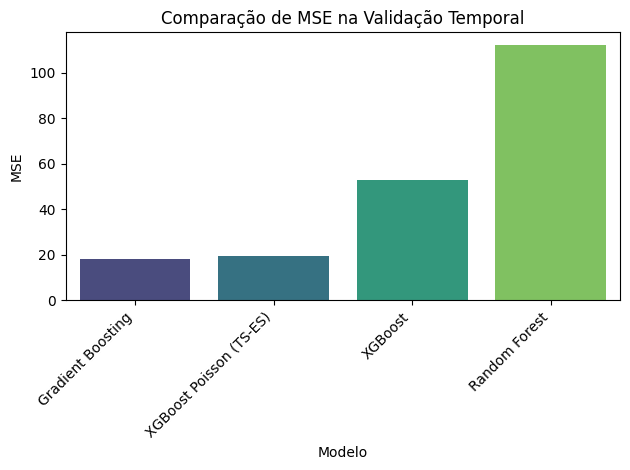

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

Epoch 1/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 34.4036 - val_loss: 39.3908 - learning_rate: 0.0010
Epoch 2/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 32.4936 - val_loss: 35.6225 - learning_rate: 0.0010
Epoch 3/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 28.5388 - val_loss: 32.0375 - learning_rate: 0.0010
Epoch 4/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 26.1050 - val_loss: 29.8824 - learning_rate: 0.0010
Epoch 5/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 24.6466 - val_loss: 28.1246 - learning_rate: 0.0010
Epoch 6/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 23.7224 - val_loss: 26.8966 - learning_rate: 0.0010
Epoch 7/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 23.2056 - val_loss: 25.9871 - learning_rate: 0.0010
Epoch 8/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 22.8221 - val_loss: 24.5926 - learning_rate: 0.0010
Epoch 9/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 21.0849 - val_loss: 23.0588 - learning_rate

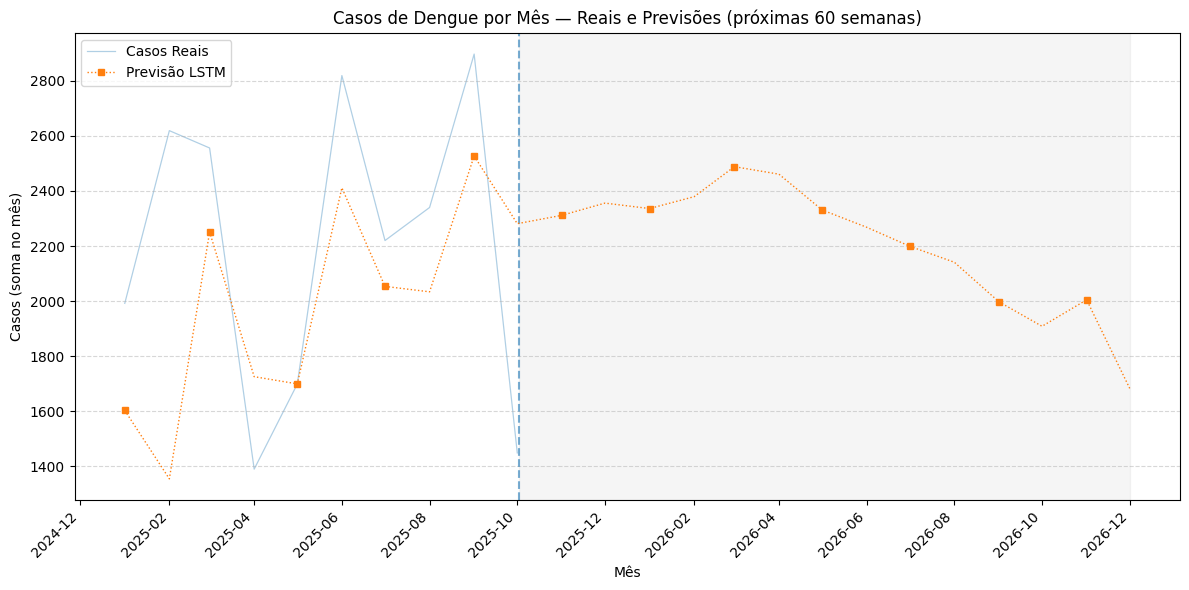

In [ ]:
# ===============================================================
# === 5. EXECUÇÃO COMPLETA  (TS-SPLIT, XGB Poisson, LSTM e PLOT MENSAL) ===
# ===============================================================
# Este pipeline integra:
# 1) Download e preparação dos dados
# 2) Engenharia de features (lags, médias móveis, componentes sazonais)
# 3) Treinamento temporal de modelos clássicos (+ XGB Poisson com early stopping)
# 4) Treinamento LSTM em janelas por estado e previsão iterativa
# 5) Geração de previsões futuras (semanas -> agregação mensal) e plot
# Observação: requer as funções definidas previamente:
#   - baixar_dados_por_estado, carregar_e_limpar, adicionar_variaveis_temporais, remover_outliers
#   - treinar_lstm_separado (ou a versão abaixo já incluída no arquivo)
# ===============================================================

# --- Imports centrais do pipeline (redundantes caso já estejam no topo do seu script) ---
import os
from glob import glob
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.dates as mdates

# xgboost
import xgboost as xgb
from xgboost import XGBRegressor

# modelos clássicos e métricas
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# LSTM
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.losses import Huber  # Perda robusta para lidar com outliers

# ---- (Opcional) Reprodutibilidade leve ----
import random
np.random.seed(42); random.seed(42); tf.random.set_seed(42)

# --------------------------
# Configuração de anos (um único range para todo o pipeline)
# --------------------------
ANO_INICIO = 2010
ANO_FIM    = 2025  # use year atual se preferir: datetime.now().year

# ====== Horizonte de previsão (semanas) ======
# 26 ≈ 6 meses | 52 ≈ 1 ano
N_FUTURO_SEMANAS = 60

# --------------------------
# Helpers gerais
# --------------------------
def yw_to_month_start(y, w):
    """Converte (ano ISO, semana ISO) no primeiro dia do mês correspondente.
       Resiliente à semana 53."""
    y, w = int(y), int(w)
    try:
        d = date.fromisocalendar(y, w, 1)
    except ValueError:
        d = date.fromisocalendar(y, 52, 1)  # fallback em anos sem iso-week 53
    return d.replace(day=1)

def _ord_from_year_week(y, w):
    """YYYYWW inteiro para ordenações/splits temporais."""
    return int(f"{int(y):04d}{int(w):02d}")

# ===== Engenharia de features rápida =====
def add_extra_features(df):
    g = df.sort_values(
        ["codigo_ibge","epidemiological_year","epidemiological_week"]
    ).copy()

    # --- lags de casos
    for lag in [1,2,3,4,8,12]:
        g[f"casos_lag_{lag}"] = g.groupby("codigo_ibge")["casos"].shift(lag)

    # --- médias móveis de casos (curtas)
    g["casos_mm3"] = g.groupby("codigo_ibge")["casos"].rolling(3).mean().reset_index(0,drop=True)
    g["casos_mm5"] = g.groupby("codigo_ibge")["casos"].rolling(5).mean().reset_index(0,drop=True)

    # --- sazonalidade (Fourier ordem 1)
    w = g["epidemiological_week"].astype(float)
    g["week_sin"] = np.sin(2*np.pi*w/52.18)
    g["week_cos"] = np.cos(2*np.pi*w/52.18)

    # --- clima com lags longos (picos de dengue costumam vir 4–8 semanas depois)
    for col in ["tempmin","umidmax"]:
        if col in g.columns:
            for lag in [1,2,4,6,8]:
                g[f"{col}_lag{lag}"] = g.groupby("codigo_ibge")[col].shift(lag)
            # médias móveis climáticas (inércia de ambiente)
            g[f"{col}_mm4"] = g.groupby("codigo_ibge")[col].rolling(4).mean().reset_index(0,drop=True)
            g[f"{col}_mm8"] = g.groupby("codigo_ibge")[col].rolling(8).mean().reset_index(0,drop=True)

    return g

# --------------------------
# LSTM — construção de janelas e máscara temporal (versão local do bloco 3.2)
# --------------------------
def _build_sequences_by_state(df, features, lookback=8, horizon=1):
    """Monta tensores 3D (amostras, lookback, n_features) por estado."""
    X_list, y_list = [], []
    df = df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
    for gid, g in df.groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")
        feats_arr = g[features].to_numpy(dtype=float)
        target_arr = g["casos"].to_numpy(dtype=float)
        if len(g) < lookback + horizon:
            continue
        for t in range(lookback, len(g) - horizon + 1):
            X_list.append(feats_arr[t - lookback:t])
            y_list.append(target_arr[t + horizon - 1])
    X = np.array(X_list); y = np.array(y_list)
    return X, y

def _temporal_mask_by_cutoff(df, lookback, horizon, cutoff=(2025,1)):
    """Máscara booleana alinhada às janelas: True=train; False=test, por cutoff ISO."""
    ord_cut = _ord_from_year_week(*cutoff)
    mask_list = []
    for gid, g in df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")
        if len(g) < lookback + horizon:
            continue
        ord_vec = g["ord"].to_numpy()
        for t in range(lookback, len(g) - horizon + 1):
            ord_target = ord_vec[t + horizon - 1]
            mask_list.append(ord_target < ord_cut)
    return np.array(mask_list, dtype=bool)

def treinar_lstm_separado(
    df_feat_sem_outliers,
    features,
    lookback=12,
    horizon=1,
    cutoff_test=(2025,1),
    epochs=120,
    batch_size=256,
    lr=1e-3,
    verbose=1
):
    """
    Treina LSTM agregando janelas de todas as capitais (multi-séries).
    Retorna métricas de teste, o modelo e o scaler para reuso em previsão.
    """
    df_seq = df_feat_sem_outliers.copy()
    df_seq[features] = df_seq[features].ffill().bfill()
    df_seq["casos"] = df_seq["casos"].astype(float)

    X_all, y_all = _build_sequences_by_state(df_seq, features, lookback=lookback, horizon=horizon)
    if len(X_all) == 0:
        raise ValueError("Sem dados suficientes para LSTM. Verifique lookback/horizon.")

    mask_train = _temporal_mask_by_cutoff(df_seq, lookback, horizon, cutoff=cutoff_test)
    if mask_train.shape[0] != X_all.shape[0]:
        raise RuntimeError("Máscara temporal desalinhada.")

    X_tr, y_tr = X_all[mask_train], y_all[mask_train]
    X_te, y_te = X_all[~mask_train], y_all[~mask_train]

    n_features = X_tr.shape[-1]
    scaler = StandardScaler()
    X_tr_2d = X_tr.reshape(-1, n_features)
    scaler.fit(X_tr_2d)
    X_tr_scaled = scaler.transform(X_tr_2d).reshape(X_tr.shape)
    X_te_scaled = scaler.transform(X_te.reshape(-1, n_features)).reshape(X_te.shape)

    def build_lstm(input_shape, lr=lr):
        inp = layers.Input(shape=input_shape)
        x = layers.LSTM(64, return_sequences=True)(inp)
        x = layers.Dropout(0.2)(x)
        x = layers.LSTM(32)(x)
        x = layers.Dense(16, activation="relu")(x)
        out = layers.Dense(1, activation="softplus")(x)  # saída positiva e suave
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=Huber(delta=1.0))
        return model

    model_lstm = build_lstm((lookback, n_features), lr=lr)
    early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    plateau = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")

    model_lstm.fit(
        X_tr_scaled, y_tr,
        validation_split=0.15,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early, plateau],
        verbose=verbose
    )

    def _metrics(y_true, y_pred):
        mse = np.mean((y_true - y_pred) ** 2)
        rmse = float(np.sqrt(mse))
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
        nrmse_pct = (rmse / np.mean(y_true)) * 100 if np.mean(y_true) != 0 else np.nan
        return mse, rmse, r2, nrmse_pct

    y_hat_tr = model_lstm.predict(X_tr_scaled, verbose=0).ravel()
    y_hat_te = model_lstm.predict(X_te_scaled, verbose=0).ravel()

    mse_tr, rmse_tr, r2_tr, nrmse_tr = _metrics(y_tr, y_hat_tr)
    mse_te, rmse_te, r2_te, nrmse_te = _metrics(y_te, y_hat_te)

    print("\n=== LSTM - Métricas (Treino) ===")
    print(f"MSE (u²): {mse_tr:,.2f} | RMSE: {rmse_tr:,.2f} | R²: {r2_tr*100:,.2f}% | nRMSE: {nrmse_tr:,.2f}%")
    print("=== LSTM - Métricas (Teste)  ===")
    print(f"MSE (u²): {mse_te:,.2f} | RMSE: {rmse_te:,.2f} | R²: {r2_te*100:,.2f}% | nRMSE: {nrmse_te:,.2f}%")

    resultados_lstm = {"LSTM": (mse_te, rmse_te, r2_te, nrmse_te)}
    return resultados_lstm, model_lstm, scaler, lookback

# ===== previsão LSTM para N semanas (genérica) =====
def prever_n_semanas_lstm(df_feat_sem_outliers, features, model_lstm, scaler, lookback, n_weeks=26):
    """
    Faz previsão iterativa semana-a-semana, por estado, atualizando lags compatíveis.
    Retorna DataFrame com colunas: codigo_ibge, epidemiological_year, epidemiological_week, casos_previstos_lstm
    """
    df = df_feat_sem_outliers.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
    last_windows = {}
    for gid, g in df.groupby("codigo_ibge"):
        if len(g) < lookback:
            continue
        last_windows[gid] = g.iloc[-lookback:].copy()

    fut_rows = []
    # índices em 'features' que precisam ser atualizados durante a simulação
    idx_lag1 = features.index("casos_lag_1") if "casos_lag_1" in features else None
    idx_med3 = features.index("casos_media_3") if "casos_media_3" in features else None

    for gid, win_df in last_windows.items():
        win_vals = win_df[features].to_numpy(dtype=float)  # (lookback, n_features)
        y_last = int(win_df.iloc[-1]["epidemiological_year"])
        w_last = int(win_df.iloc[-1]["epidemiological_week"])

        for _ in range(n_weeks):
            X_in = scaler.transform(win_vals)
            y_pred = float(model_lstm.predict(X_in[np.newaxis, ...], verbose=0).ravel()[0])
            y_pred = max(0.0, y_pred)
            # aplica teto FUT_CAP se definido globalmente
            if 'FUT_CAP' in globals() and FUT_CAP is not None:
                y_pred = min(y_pred, FUT_CAP)

            # atualiza lags/médias para a próxima janela
            new_row = win_vals[-1].copy()
            if idx_lag1 is not None:
                new_row[idx_lag1] = y_pred
            if idx_med3 is not None:
                last_lag1_series = win_vals[-2:, idx_lag1] if win_vals.shape[0] >= 2 else np.array([])
                vals = list(last_lag1_series) + [y_pred]
                new_row[idx_med3] = np.mean(vals)

            # avança 1 semana ISO
            d = date.fromisocalendar(y_last, w_last, 1) + timedelta(weeks=1)
            iso = d.isocalendar(); y_last, w_last = int(iso[0]), int(iso[1])

            fut_rows.append({
                "codigo_ibge": gid,
                "epidemiological_year": y_last,
                "epidemiological_week": w_last,
                "casos_previstos_lstm": y_pred
            })
            # janela deslizante
            win_vals = np.vstack([win_vals[1:], new_row])

    return pd.DataFrame(fut_rows)

# --------------------------
# Modelos clássicos com split temporal + XGB Poisson (early stopping)
# --------------------------
def treinar_modelos(X, y, ord_vec, val_weeks=26):
    """
    Split temporal: últimas `val_weeks` semanas = validação.
    Retorna:
        resultados: dict {nome_modelo: (mse, r2)}
        modelos_treinados: dict {nome_modelo: estimator_com_predict}
    """
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    import xgboost as xgb
    from xgboost import XGBRegressor

    # --- split temporal
    ords = np.sort(np.unique(ord_vec))
    if len(ords) == 0:
        raise ValueError("ord_vec vazio.")

    val_ords = ords[-val_weeks:] if len(ords) > val_weeks else ords[-max(1, len(ords)//5):]
    mask_val = np.isin(ord_vec, val_ords)
    mask_tr  = ~mask_val

    X_tr, y_tr = X[mask_tr], y[mask_tr]
    X_val, y_val = X[mask_val], y[mask_val]

    # --- pesos temporais (levemente mais peso p/ recente)
    w_tr = time_weights(ord_vec[mask_tr], power=1.0)

    # --- modelos sklearn "clássicos"
    modelos = {
      #  "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(
            random_state=42, n_estimators=800, max_features="sqrt",
            max_depth=12, min_samples_leaf=5
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            random_state=42, n_estimators=1000, learning_rate=0.05, max_depth=3
        ),
        "XGBoost": XGBRegressor(

          objective="count:poisson",
          tree_method="hist",
          random_state=42,
          learning_rate=0.03,      # antes geralmente 0.1
          n_estimators=1200,       # mais árvores, aprendizado mais fino
          max_depth=4,             # evita overfitting local
          min_child_weight=2,
          subsample=0.8,
          colsample_bytree=0.8,
          reg_lambda=1.0,          # L2
          reg_alpha=0.1            # L1 leve


        ),
    }

    resultados = {}
    modelos_treinados = {}

    # --- treina modelos clássicos
    for nome, modelo in modelos.items():
        try:
            # Linear Regression: NÃO usa sample_weight
            if isinstance(modelo, LinearRegression):
                modelo.fit(X_tr, y_tr)
            else:
                # demais modelos: tenta usar sample_weight; se não aceitar, vai sem
                try:
                    modelo.fit(X_tr, y_tr, sample_weight=w_tr)
                except TypeError:
                    modelo.fit(X_tr, y_tr)

            # predição na validação temporal
            y_hat = modelo.predict(X_val)
            mse = mean_squared_error(y_val, y_hat)
            r2  = r2_score(y_val, y_hat)

            resultados[nome] = (float(mse), float(r2))
            modelos_treinados[nome] = modelo

        except Exception as e:
            print(f"[AVISO] Falha ao treinar {nome}: {e}")

    # --- XGBoost Poisson com early stopping via xgb.train
    try:
        dtr  = xgb.DMatrix(X_tr, label=y_tr, weight=w_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        params = {
            "objective": "count:poisson",
            "eval_metric": "poisson-nloglik",
            "tree_method": "hist",
            "random_state": 42,
            "eta": 0.03,
            "max_depth": 4,
            "min_child_weight": 5,
            "subsample": 0.9,
            "colsample_bytree": 0.9,
            "lambda": 2.0,   # L2
            "alpha": 0.1     # L1
        }

        booster = xgb.train(
            params,
            dtr,
            num_boost_round=5000,
            evals=[(dval, "val")],
            early_stopping_rounds=200,
            verbose_eval=False
        )

        class XGBPoissonWrapper:
            def __init__(self, booster):
                self.booster = booster
            def predict(self, X_):
                return self.booster.predict(xgb.DMatrix(X_))

        xgb_poisson_model = XGBPoissonWrapper(booster)
        y_hat_p = xgb_poisson_model.predict(X_val)
        mse_p = mean_squared_error(y_val, y_hat_p)
        r2_p  = r2_score(y_val, y_hat_p)

        resultados["XGBoost Poisson (TS-ES)"] = (float(mse_p), float(r2_p))
        modelos_treinados["XGBoost Poisson (TS-ES)"] = xgb_poisson_model

    except Exception as e:
        print(f"[AVISO] Falha no XGBoost Poisson (TS-ES): {e}")

    # --- sanity check e retorno GARANTIDO
    if not resultados:
        raise RuntimeError("Nenhum modelo foi treinado com sucesso; 'resultados' ficou vazio.")

    return resultados, modelos_treinados

    # --- treina modelos clássicos com proteção de erro
    for nome, modelo in modelos.items():
        try:
            try:
                modelo.fit(X_tr, y_tr, sample_weight=w_tr)
            except TypeError:
                modelo.fit(X_tr, y_tr)
            y_hat = modelo.predict(X_val)
            mse = mean_squared_error(y_val, y_hat)
            r2  = r2_score(y_val, y_hat)
            resultados[nome] = (float(mse), float(r2))
            modelos_treinados[nome] = modelo
        except Exception as e:
            print(f"[AVISO] Falha ao treinar {nome}: {e}")

    # --- XGBoost Poisson com early stopping via xgb.train
    try:
        dtr  = xgb.DMatrix(X_tr, label=y_tr, weight=w_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        params = {
            "objective": "count:poisson",
            "eval_metric": "poisson-nloglik",
            "tree_method": "hist",
            "random_state": 42,
            "eta": 0.03,
            "max_depth": 4,
            "min_child_weight": 5,
            "subsample": 0.9,
            "colsample_bytree": 0.9,
            "lambda": 2.0,   # L2
            "alpha": 0.1     # L1
        }

        booster = xgb.train(
            params,
            dtr,
            num_boost_round=5000,
            evals=[(dval, "val")],
            early_stopping_rounds=200,
            verbose_eval=False
        )

        class XGBPoissonWrapper:
            def __init__(self, booster):
                self.booster = booster
            def predict(self, X_):
                return self.booster.predict(xgb.DMatrix(X_))

        xgb_poisson_model = XGBPoissonWrapper(booster)
        y_hat_p = xgb_poisson_model.predict(X_val)
        mse_p = mean_squared_error(y_val, y_hat_p)
        r2_p  = r2_score(y_val, y_hat_p)

        resultados["XGBoost Poisson (TS-ES)"] = (float(mse_p), float(r2_p))
        modelos_treinados["XGBoost Poisson (TS-ES)"] = xgb_poisson_model

    except Exception as e:
        print(f"[AVISO] Falha no XGBoost Poisson (TS-ES): {e}")

    # --- sanity check e retorno GARANTIDO
    if not resultados:
        raise RuntimeError("Nenhum modelo foi treinado com sucesso; 'resultados' ficou vazio.")

    return resultados, modelos_treinados

# --------------------------
# Fluxo principal
# --------------------------

# Passo 1 — Download com o mesmo range usado no restante do pipeline
baixar_dados_por_estado(ano_inicio=ANO_INICIO, ano_fim=ANO_FIM)

# Passo 2 — Carregar o arquivo correto (com fallback se não existir)
caminho_csv = f"data/raw/dengue_{ANO_INICIO}_{ANO_FIM}_por_estado.csv"
if not os.path.exists(caminho_csv):
    candidatos = sorted(glob("data/raw/dengue_*_por_estado.csv"))
    if candidatos:
        print(f" Arquivo {caminho_csv} não encontrado. Usando {candidatos[-1]}")
        caminho_csv = candidatos[-1]
    else:
        raise FileNotFoundError("Nenhum CSV de dengue encontrado em data/raw/. Verifique o download.")

# Carrega e aplica engenharia básica
df = carregar_e_limpar(caminho_csv)
df_feat = adicionar_variaveis_temporais(df)
df_feat = add_extra_features(df_feat)  # novas features

# Preenche NaNs (lags iniciais e possíveis faltas de clima/população)
df_feat = df_feat.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
cols_to_fill = list(set([
    "casos",
    "casos_lag_1","casos_lag_2","casos_lag_3","casos_lag_4","casos_lag_8","casos_lag_12",
    "casos_mm3",
    "week_sin","week_cos",
    "pop","tempmin_lag1","tempmin_lag2","umidmax_lag1","umidmax_lag2",
    "receptivo","transmissao",
    "casos_media_3"
]))

for col in cols_to_fill:
    if col in df_feat.columns:
        df_feat[col] = df_feat.groupby("codigo_ibge")[col].transform(lambda s: s.ffill().bfill())

# Se "casos_media_3" não existia, cria a partir dos lags
if "casos_media_3" in df_feat.columns:
    mask_missing = df_feat["casos_media_3"].isna()
    if mask_missing.any():
        df_feat.loc[mask_missing, "casos_media_3"] = (
            df_feat.loc[mask_missing, ["casos_lag_1","casos_lag_2","casos_lag_3"]].mean(axis=1)
        )

# Seleção de features (inclui as novas criadas)
# Lista de features desejadas
features_desejadas = [
    # casos
    "casos_lag_1","casos_lag_2","casos_lag_3","casos_lag_4","casos_lag_8","casos_lag_12",
    "casos_mm3","casos_mm5",
    # sazonalidade
    "week_sin","week_cos",
    # demografia/clima (atuais)
    "pop","tempmin","umidmax",
    # clima defasado e suavizado
    "tempmin_lag1","tempmin_lag2","tempmin_lag4","tempmin_lag6","tempmin_lag8","tempmin_mm4","tempmin_mm8",
    "umidmax_lag1","umidmax_lag2","umidmax_lag4","umidmax_lag6","umidmax_lag8","umidmax_mm4","umidmax_mm8",
    # receptividade/transmissão (se existirem)
    "receptivo","transmissao",
    # compat LSTM
    "casos_media_3"
]

# Mantém apenas as colunas que realmente existem no df_feat
features = [col for col in features_desejadas if col in df_feat.columns]

print("Features usadas no pipeline:")
print(features)


# Remoção de outliers nas features (conforme seu bloco 2)
df_feat_sem_outliers = remover_outliers(df_feat, features)

# Vetor temporal para split/weights
ord_vec = (df_feat_sem_outliers["epidemiological_year"].astype(int)*100 +
           df_feat_sem_outliers["epidemiological_week"].astype(int)).values

# Matrizes de treino
X = df_feat_sem_outliers[features].values
y = df_feat_sem_outliers["casos"].values.astype(float)

# Teto de segurança para previsões futuras (evita explosões)
p98 = np.percentile(y[~np.isnan(y)], 98)
FUT_CAP = float(p98 * 1.75)  # era 1.25

# Treino temporal + Early Stopping
resultados, modelos_treinados = treinar_modelos(X, y, ord_vec, val_weeks=26)

# Escolha automática do melhor (menor MSE)
modelo_escolhido_nome = min(resultados.keys(), key=lambda k: resultados[k][0])
modelo_escolhido = modelos_treinados[modelo_escolhido_nome]
print(f"\n>>> Modelo escolhido: {modelo_escolhido_nome}")

# ===== Avaliação (val temporal) — gráfico de MSE
df_mse = (
    pd.DataFrame([(k, v[0]) for k, v in resultados.items()], columns=["Modelo","MSE"])
      .sort_values("MSE")
)
sns.barplot(data=df_mse, x="Modelo", y="MSE", hue="Modelo", palette="viridis", legend=False)
plt.title("Comparação de MSE na Validação Temporal")
plt.ylabel("MSE"); plt.xlabel("Modelo"); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# ===== Previsões no histórico (in-sample) com o modelo escolhido
df_feat_sem_outliers["casos_previstos_in_sample"] = np.clip(modelo_escolhido.predict(X), 0, None)

# ===== Função para avançar 1 semana ISO (vetorizado)
def advance_iso_week_vectorized(years, weeks):
    new_years, new_weeks = [], []
    for y_, w_ in zip(years, weeks):
        d = date.fromisocalendar(int(y_), int(w_), 1) + timedelta(weeks=1)
        iso = d.isocalendar()
        new_years.append(int(iso[0])); new_weeks.append(int(iso[1]))
    return pd.Series(new_years), pd.Series(new_weeks)

# ===== Preparação dos últimos registros por estado (seed de previsão)
ultimos_registros = (
    df_feat_sem_outliers
    .sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"])
    .groupby("codigo_ibge").tail(1).copy()
)
# Garante colunas de lags fundamentais
for col in ["casos_lag_1","casos_lag_2","casos_lag_3","casos_media_3"]:
    if col not in ultimos_registros.columns:
        ultimos_registros[col] = np.nan
ultimos_registros["casos_lag_1"] = ultimos_registros["casos_lag_1"].fillna(ultimos_registros.get("casos", 0))
ultimos_registros["casos_lag_2"] = ultimos_registros["casos_lag_2"].fillna(ultimos_registros["casos_lag_1"])
ultimos_registros["casos_lag_3"] = ultimos_registros["casos_lag_3"].fillna(ultimos_registros["casos_lag_2"])
ultimos_registros["casos_media_3"] = ultimos_registros["casos_media_3"].fillna(
    ultimos_registros[["casos_lag_1","casos_lag_2","casos_lag_3"]].mean(axis=1)
)

# ===== Previsão de N_FUTURO_SEMANAS (modelo escolhido — iterativa)
previsoes_futuras = []

# ordem de atualização dos lags (do maior para o menor)
_LAG_ORDER = [12, 8, 4, 3, 2]  # lag_1 será o y_pred

for _ in range(N_FUTURO_SEMANAS):
    X_input = ultimos_registros[features].copy()

    # previsão com teto FUT_CAP
    y_pred = np.clip(modelo_escolhido.predict(X_input), 0, FUT_CAP)

    # === atualiza lags: lag_k <- lag_{k-1} ; lag_1 <- y_pred ===
    for k in _LAG_ORDER:
        src = 1 if k == 2 else (k - 1)  # para k=2, vem de lag_1; demais, padrão k-1
        ultimos_registros[f"casos_lag_{k}"] = ultimos_registros.get(f"casos_lag_{src}", ultimos_registros["casos_lag_1"])

    ultimos_registros["casos_lag_1"] = y_pred

    # === atualiza médias derivadas dos lags ===
    ultimos_registros["casos_media_3"] = ultimos_registros[["casos_lag_1","casos_lag_2","casos_lag_3"]].mean(axis=1)
    ultimos_registros["casos_mm3"]     = ultimos_registros["casos_media_3"]  # coerência com definição (média de 3 lags)

    # avança semana ISO
    new_years, new_weeks = advance_iso_week_vectorized(
        ultimos_registros["epidemiological_year"].values,
        ultimos_registros["epidemiological_week"].values
    )
    ultimos_registros["epidemiological_year"] = new_years.values
    ultimos_registros["epidemiological_week"] = new_weeks.values

    snap = ultimos_registros.copy()
    snap["casos_previstos"] = y_pred
    previsoes_futuras.append(snap)

df_previsoes_futuras = pd.concat(previsoes_futuras, ignore_index=True).assign(
    casos_previstos=lambda d: d["casos_previstos"].astype(float)
)

# === Suavização das previsões semanais (EMA) ===
def suavizar_previsoes(df, col="casos_previstos", alpha=0.35):
    """Aplica suavização exponencial progressiva ao horizonte futuro."""
    vals = df[col].values.astype(float)
    out = np.zeros_like(vals)
    out[0] = vals[0]
    for i in range(1, len(vals)):
        out[i] = alpha * vals[i] + (1 - alpha) * out[i-1]
    df[col] = out
    return df

# Aplica suavização individual por UF (ou IBGE)
previsoes_futuras_suave = (
    df_previsoes_futuras
    .groupby("codigo_ibge", group_keys=False)
    .apply(lambda g: suavizar_previsoes(g.sort_values(["epidemiological_year","epidemiological_week"]),
                                        col="casos_previstos", alpha=0.45))
)

# ===== Treina LSTM e prevê N_FUTURO_SEMANAS
res_lstm, model_lstm, scaler_lstm, lookback = treinar_lstm_separado(
    df_feat_sem_outliers, features,
    lookback=12, horizon=1, cutoff_test=(2025,1),
    epochs=120, batch_size=256, lr=1e-3, verbose=1
)
df_previsoes_futuras_lstm = prever_n_semanas_lstm(
    df_feat_sem_outliers, features, model_lstm, scaler_lstm, lookback,
    n_weeks=N_FUTURO_SEMANAS
)

# ===== Agregação mensal (reais e previsões)
# Reais
real_m = df_feat_sem_outliers.copy()
real_m["mes_dt"] = real_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
real_m = real_m.groupby("mes_dt")["casos"].sum().reset_index().rename(columns={"casos":"Casos Reais"})

# Clássico escolhido
xgb_m = df_previsoes_futuras.copy()
xgb_m["mes_dt"] = xgb_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
xgb_m = xgb_m.groupby("mes_dt")["casos_previstos"].sum().reset_index().rename(columns={"casos_previstos":f"Previsão {modelo_escolhido_nome}"})

# LSTM
lstm_m = df_previsoes_futuras_lstm.copy()
lstm_m["mes_dt"] = lstm_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
lstm_m = lstm_m.groupby("mes_dt")["casos_previstos_lstm"].sum().reset_index().rename(columns={"casos_previstos_lstm":"Previsão LSTM"})

# Unifica e ordena
df_month = (real_m.merge(xgb_m, on="mes_dt", how="outer")
                  .merge(lstm_m, on="mes_dt", how="outer")
                  .sort_values("mes_dt"))

ultimo_mes_real = real_m["mes_dt"].max() if len(real_m) else None

# === Trilhos sazonais por mês (blend com mediana histórica + teto p90*1.10) ===
if len(real_m):
    real_hist = real_m[real_m["mes_dt"] <= ultimo_mes_real].copy() if ultimo_mes_real is not None else real_m.copy()
    real_hist["mes_num"] = pd.to_datetime(real_hist["mes_dt"]).dt.month
    saz = (real_hist
           .groupby("mes_num")["Casos Reais"]
           .agg(mediana="median", p90=lambda s: np.percentile(s, 90))
           .reset_index())
    saz_map = {int(r.mes_num): (float(r.mediana), float(r.p90) * 1.10)
               for r in saz.itertuples(index=False)}

    def aplica_trilhos(col):
        """Faz blend com a mediana do mês e aplica teto sazonal p90*1.10."""
        if col not in df_month.columns:
            return
        mask_fut = df_month["mes_dt"] > ultimo_mes_real if ultimo_mes_real is not None else df_month["mes_dt"] >= df_month["mes_dt"].min()
        if not mask_fut.any():
            return

        meses = pd.to_datetime(df_month.loc[mask_fut, "mes_dt"]).dt.month
        preds = df_month.loc[mask_fut, col].astype(float).values

        alpha = 0.85  # peso da previsão no blend (ajuste conforme calibragem desejada)
        blends = []
        for val, m in zip(preds, meses):
            med, cap = saz_map.get(int(m), (np.nan, np.nan))
            if not np.isfinite(med):
                med = np.nanmedian(preds)
            if not np.isfinite(cap):
                cap = np.nanpercentile(preds, 90) * 1.10
            b = alpha * val + (1 - alpha) * med   # aproxima da mediana sazonal
            b = min(b, cap)                        # teto sazonal
            blends.append(b)

        df_month.loc[mask_fut, col] = blends

    aplica_trilhos(f"Previsão {modelo_escolhido_nome}")
    aplica_trilhos("Previsão LSTM")

# === Suavização EMA no trecho futuro (deixa horizonte mais uniforme)
def _ema(series, alpha=0.35):
    vals = series.values.astype(float)
    if len(vals) == 0: return series
    out = np.empty_like(vals, dtype=float)
    out[0] = vals[0]
    for i in range(1, len(vals)):
        out[i] = alpha*vals[i] + (1-alpha)*out[i-1]
    return pd.Series(out, index=series.index)

if ultimo_mes_real is not None:
    mask_fut = df_month["mes_dt"] > ultimo_mes_real
    for col in [f"Previsão {modelo_escolhido_nome}", "Previsão LSTM"]:
        if col in df_month.columns:
            df_month.loc[mask_fut, col] = _ema(
                df_month.loc[mask_fut, col].ffill().bfill()
            )

# === PRINT: métricas por modelo (validação temporal) ===
print("\n=== Métricas por modelo (validação temporal) ===")
df_scores = (
    pd.DataFrame(
        [(nome, met[0], met[1]) for nome, met in resultados.items()],
        columns=["Modelo", "MSE", "R2"]
    )
    .sort_values("MSE")
)

# formatação bonita
with pd.option_context('display.float_format', lambda x: f'{x:,.4f}'):
    print(df_scores.to_string(index=False))

# também deixa claro o melhor pelo MSE
melhor_nome = df_scores.iloc[0, 0]
melhor_mse  = df_scores.iloc[0, 1]
print(f"\n>>> Melhor pelo MSE: {melhor_nome} (MSE={melhor_mse:,.4f})")

from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.dates as mdates

# --- Prepara datas e recorte a partir de um cutoff (se quiser manter) ---
df_month["mes_dt"] = pd.to_datetime(df_month["mes_dt"], errors="coerce")
cutoff_dt = pd.Timestamp("2025-01-01")
df_plot = df_month[df_month["mes_dt"] >= cutoff_dt].copy()

# nomes de colunas
col_real = "Casos Reais"
col_xgb  = f"Previsão {modelo_escolhido_nome}"
col_lstm = "Previsão LSTM"

# --- 1) Calibração da previsão do modelo escolhido (XGBoost etc.) ---

# usa apenas meses onde temos real e previsão juntos
df_calib = df_plot[["mes_dt", col_real, col_xgb]].dropna()
if len(df_calib) > 0:
    X_cal = df_calib[[col_xgb]].values
    y_cal = df_calib[col_real].values

    reg = LinearRegression()
    reg.fit(X_cal, y_cal)
    alpha = float(reg.coef_[0])
    beta  = float(reg.intercept_)
    print(f"[Mensal] Correção aplicada: y_corrig = {alpha:.4f} * y_pred + {beta:.4f}")

    # aplica calibração a todos os meses (inclui futuro)
    df_plot["Prev_xgb_cal"] = alpha * df_plot[col_xgb] + beta
else:
    # se não der pra calibrar, usa a previsão original
    df_plot["Prev_xgb_cal"] = df_plot[col_xgb]

# --- 2) Ajuste de continuidade: cola o primeiro previsto no último mês real ---

df_real = df_plot[["mes_dt", col_real]].dropna()
df_xgb_cal = df_plot[["mes_dt", "Prev_xgb_cal"]].dropna()
df_lstm = df_plot[["mes_dt", col_lstm]].dropna()

col_real = "Casos Reais"
col_xgb  = f"Previsão {modelo_escolhido_nome}"

# série original do XGBoost
serie_xgb = df_xgb[col_xgb].astype(float).copy()

if not df_real.empty and not df_xgb.empty:
    # último mês com dado real
    ultimo_mes_real = df_real["mes_dt"].max()
    y_real_ultimo = df_real.loc[df_real["mes_dt"] == ultimo_mes_real, col_real].iloc[0]

    # índice do primeiro mês previsto depois do último real
    mask_future = df_xgb["mes_dt"] > ultimo_mes_real

    if mask_future.any():
        idx_first_future = df_xgb.index[mask_future][0]
        y_pred_first = float(serie_xgb.loc[idx_first_future])

        # ===== BLEND: mistura real e previsto no 1º mês de previsão =====
        w = 0.4  # 40% real, 60% previsto (ajuste fino aqui se quiser)
        blended_first = w * y_real_ultimo + (1 - w) * y_pred_first

        # seta o 1º ponto futuro como mistura (em vez de prever tão baixo)
        serie_xgb.loc[idx_first_future] = blended_first

        # ===== SUAVIZAÇÃO LEVE APENAS NOS FUTUROS =====
        idx_future_all = df_xgb.index[mask_future]
        serie_xgb.loc[idx_future_all] = (
            serie_xgb.loc[idx_future_all]
            .rolling(window=2, min_periods=1)
            .mean()
        )

# aplica piso zero e grava numa nova coluna
df_xgb["Prev_xgb_suav"] = serie_xgb.clip(lower=0)


if not df_real.empty and not df_xgb_cal.empty:
    # último mês com dado real
    ultimo_mes_real = df_real["mes_dt"].max()
    y_real_ultimo = df_real.loc[df_real["mes_dt"] == ultimo_mes_real, col_real].iloc[0]

    # primeiro mês previsto após esse ponto
    mask_future = df_xgb_cal["mes_dt"] > ultimo_mes_real
    if mask_future.any():
        dt_primeiro_pred = df_xgb_cal.loc[mask_future, "mes_dt"].min()
        y_primeiro_pred = df_xgb_cal.loc[df_xgb_cal["mes_dt"] == dt_primeiro_pred, "Prev_xgb_cal"].iloc[0]

        offset = float(y_primeiro_pred - y_real_ultimo)
        print(f"[Mensal] Offset de alinhamento (laranja - real) = {offset:.2f}")

        df_xgb_cal["Prev_xgb_cal"] = (df_xgb_cal["Prev_xgb_cal"] - offset).clip(lower=0)


# --- 3) Plot final (reais + previsões mensais) ---

fig, ax = plt.subplots(figsize=(12, 6))

# Casos Reais
if not df_real.empty:
    ax.plot(
        df_real["mes_dt"], df_real[col_real],
        label="Casos Reais",
        linewidth=0.9, alpha=0.35, linestyle="-", zorder=1
    )

# Previsão LSTM
if not df_lstm.empty:
    ax.plot(
        df_lstm["mes_dt"], df_lstm[col_lstm],
        label="Previsão LSTM",
        linewidth=1.0, linestyle=":", marker="s", markersize=4, markevery=2,
        zorder=6
    )

# Demarcação do futuro em relação ao último mês observado
if not df_real.empty:
    ultimo_mes_real = df_real["mes_dt"].max()
    x0 = ultimo_mes_real + timedelta(days=1)
    ax.axvline(x0, linestyle="--", alpha=0.6, zorder=2)
    xmax = df_plot["mes_dt"].max()
    if xmax is not None and xmax > x0:
        ax.axvspan(x0, xmax, color="gray", alpha=0.08, zorder=0)

ax.set_title(f"Casos de Dengue por Mês — Reais e Previsões (próximas {N_FUTURO_SEMANAS} semanas)")
ax.set_xlabel("Mês")
ax.set_ylabel("Casos (soma no mês)")
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Eixo X mensal legível
if len(df_plot):
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(df_plot)//12)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45, ha='right')

handles, labels = ax.get_legend_handles_labels()
# ordem: XGB ajustado, LSTM, Reais
order = [1, 2, 0] if len(handles) >= 3 else range(len(handles))
ax.legend([handles[i] for i in order], [labels[i] for i in order], loc="upper left")

plt.tight_layout()
plt.show()



TypeError: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.

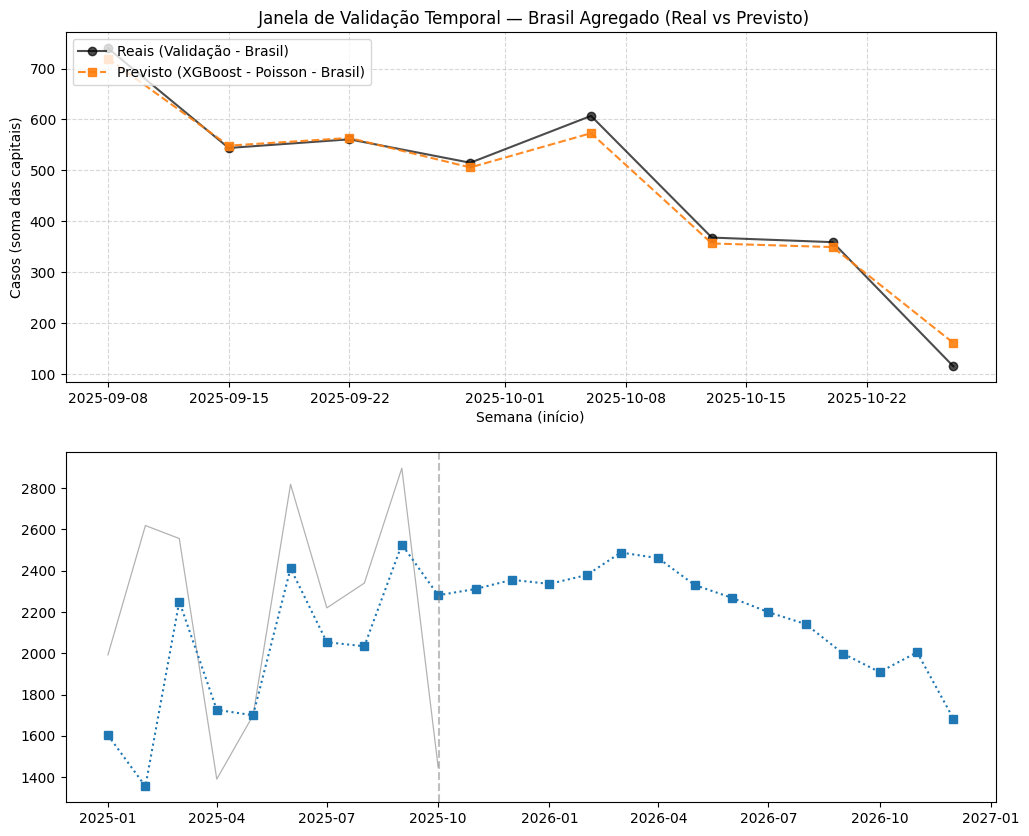

In [47]:
from datetime import date, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

# ========= GRÁFICO DE VALIDAÇÃO =========
VAL_WEEKS = 8  # use o mesmo val_weeks usado em treinar_modelos

ords = np.sort(np.unique(ord_vec))
val_ords = ords[-VAL_WEEKS:]
mask_val = np.isin(ord_vec, val_ords)

X_val = X[mask_val]
y_val = y[mask_val]
y_hat_val = modelo_escolhido.predict(X_val)

df_val = df_feat_sem_outliers.loc[mask_val, [
    "epidemiological_year",
    "epidemiological_week",
    "casos"
]].copy()

def week_start_date(y, w):
    y, w = int(y), int(w)
    try:
        return date.fromisocalendar(y, w, 1)
    except ValueError:
        return date.fromisocalendar(y, 52, 1)

# converte ano/semana em data e adiciona previsões
df_val["week_dt"] = [week_start_date(y, w) for y, w in zip(df_val["epidemiological_year"], df_val["epidemiological_week"])]
df_val["y_hat"] = y_hat_val

# AGREGAÇÃO BRASIL (soma total de casos por semana)
df_val_br = (
    df_val
    .groupby("week_dt", as_index=False)
    .agg({
        "casos": "sum",
        "y_hat": "sum"
    })
)

# ========= GRÁFICO DE FUTURO =========
df_plot_future = df_month[df_month["mes_dt"] >= pd.Timestamp("2025-01-01")].copy()

# ========= FIGURA COM DOIS SUBPLOTS =========
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

# ---  VALIDAÇÃO AGREGADA (BRASIL) ---
ax1 = axes[0]
ax1.plot(
    df_val_br["week_dt"], df_val_br["casos"],
    marker="o", linestyle="-", label="Reais (Validação - Brasil)",
    color="black", alpha=0.7
)
ax1.plot(
    df_val_br["week_dt"], df_val_br["y_hat"],
    marker="s", linestyle="--", label=f"Previsto ({modelo_escolhido_nome} - Brasil)",
    color="tab:orange", alpha=0.9
)
ax1.set_title(" Janela de Validação Temporal — Brasil Agregado (Real vs Previsto)")
ax1.set_xlabel("Semana (início)")
ax1.set_ylabel("Casos (soma das capitais)")
ax1.grid(True, linestyle="--", alpha=0.5)
ax1.legend(loc="upper left")

# --- FUTURO ---
ax2 = axes[1]
if "Casos Reais" in df_plot_future.columns:
    ax2.plot(df_plot_future["mes_dt"], df_plot_future["Casos Reais"],
             label="Casos Reais", linewidth=0.9, alpha=0.3, color="black")
if f"Previsão {modelo_escolhido_nome}" in df_plot_future.columns:
    ax2.plot(df_plot_future["mes_dt"], df_plot_future[f"Previsão {modelo_escolhido_nome}"],
             label=f"Prev. {modelo_escolhido_nome}", linestyle="--", marker="o")
if "Previsão LSTM" in df_plot_future.columns:
    ax2.plot(df_plot_future["mes_dt"], df_plot_future["Previsão LSTM"],
             label="Prev. LSTM", linestyle=":", marker="s")

# marca o corte do último mês real
ultimo_mes_real = real_m["mes_dt"].max() if len(real_m) else None
if ultimo_mes_real is not None:
    ax2.axvline(ultimo_mes_real + timedelta(days=1), linestyle="--", alpha=0.5, color="gray")
    xmax = df_plot_future["mes_dt"].max()
    if xmax > ultimo_mes_real:
        ax2.axvspan(ultimo_mes_real, xmax, color="gray", alpha=0.08)

ax2.set_title(f" Previsão de Casos Futuros — Próximas {N_FUTURO_SEMANAS} Semanas")
ax2.set_xlabel("Mês")
ax2.set_ylabel("Casos")
ax2.grid(True, linestyle="--", alpha=0.5)
ax2.legend(loc="upper left")

# --- formato de datas ---
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(df_plot_future)//12)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# ==========================
# 1. Função para categorizar casos
# ==========================
def categorizar(val):
    if val < q1: return 0   # Baixo
    elif val < q2: return 1 # Médio
    else: return 2          # Alto

# Recalcula Q1 e Q2 com base no y original
q1 = np.percentile(y, 33)
q2 = np.percentile(y, 66)

# ==========================
# 2. Tabela de métricas
# ==========================

linhas = []

media_y = float(np.mean(y)) if len(y) else np.nan

# Prepara vetor de classes reais (para acurácia)
y_cls = np.array([categorizar(v) for v in y])

# ==========================
# Modelos Clássicos
# ==========================
for nome, (mse, r2) in resultados.items():

    rmse = np.sqrt(mse)
    nrmse = (rmse / media_y * 100) if media_y != 0 else np.nan

    # Predição em todo o dataset
    y_pred = modelos_treinados[nome].predict(X)

    # Converte predições para classes
    y_pred_cls = np.array([categorizar(v) for v in y_pred])

    # Acurácia
    acc = accuracy_score(y_cls, y_pred_cls)

    linhas.append([nome, mse, rmse, r2, nrmse, acc])

# ==========================
# LSTM (se existir)
# ==========================
if "res_lstm" in globals():

    # pega métricas já calculadas
    for nome, (mse, rmse, r2, nrmse) in res_lstm.items():

        # Usa os vetores da classificação (já existentes)
        acc_lstm = accuracy_score(y_te_cls_l, y_hat_cls_l)

        linhas.append([nome, mse, rmse, r2, nrmse, acc_lstm])

# ==========================
# Monta tabela final
# ==========================
df_metricas = pd.DataFrame(
    linhas,
    columns=["Modelo", "MSE", "RMSE", "R2", "nRMSE (%)", "Acurácia"]
).sort_values("MSE").reset_index(drop=True)

# Exibe formatado
with pd.option_context("display.float_format", "{:,.4f}".format):
    print("=== Tabela de Métricas (Validação Temporal + Acurácia) ===")
    print(df_metricas.to_string(index=False))


=== Tabela de Métricas (Validação Temporal + Acurácia) ===
                 Modelo      MSE    RMSE     R2  nRMSE (%)  Acurácia
      Gradient Boosting  18.1395  4.2591 0.9856    10.8971    0.9644
XGBoost Poisson (TS-ES)  19.5454  4.4210 0.9845    11.3115    0.9829
                XGBoost  52.9570  7.2772 0.9581    18.6192    0.9436
          Random Forest 112.0370 10.5848 0.9113    27.0819    0.9131
                   LSTM 175.3438 13.2417 0.8591    19.5943    0.8949


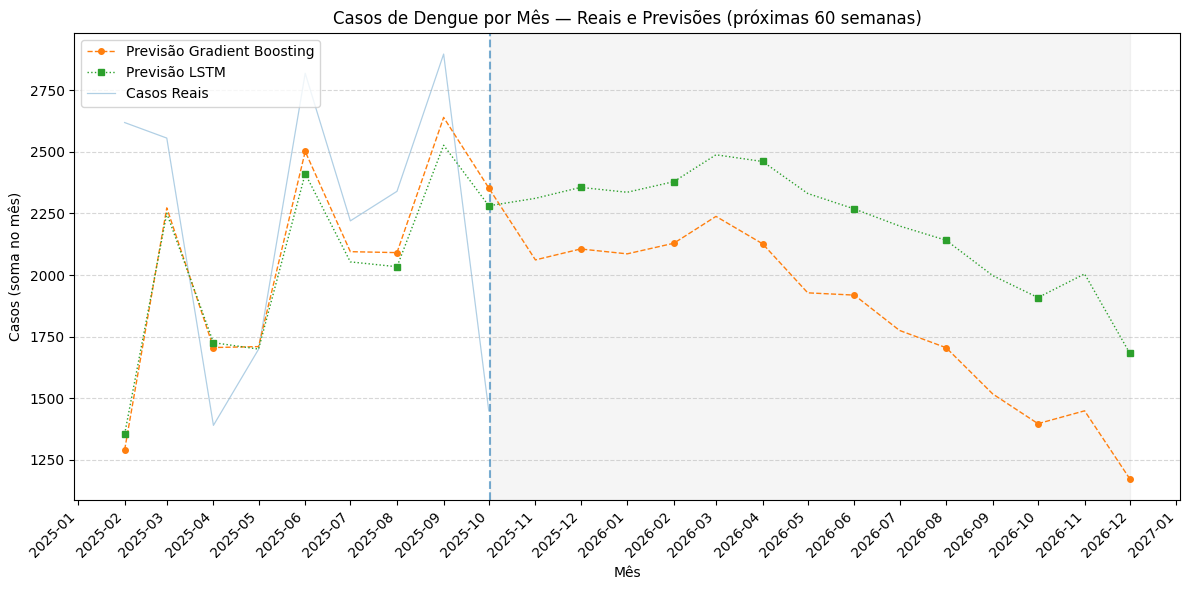

In [ ]:
# --- Plot final (reais + previsões mensais)
import pandas as pd
import matplotlib.dates as mdates
from datetime import timedelta

df_month["mes_dt"] = pd.to_datetime(df_month["mes_dt"], errors="coerce")
cutoff_dt = pd.Timestamp("2025-02-01")
df_plot = df_month[df_month["mes_dt"] >= cutoff_dt].copy()

col_real = "Casos Reais"
col_xgb  = f"Previsão {modelo_escolhido_nome}"
col_lstm = "Previsão LSTM"

df_real = df_plot[["mes_dt", col_real]].dropna()
df_xgb  = df_plot[["mes_dt", col_xgb]].dropna()
df_lstm = df_plot[["mes_dt", col_lstm]].dropna()

# ================= AJUSTE VISUAL DA LINHA LARANJA =================
# escolha UMA das opções abaixo:

# (A) AJUSTE MANUAL (defina um valor; positivo sobe, negativo desce)
OFFSET_MANUAL = -250   # ex.:  +600  ou  -300

# (B) AJUSTE AUTOMÁTICO POR MÉDIAS (aproxima a altura média do real)
USE_AUTO_OFFSET = True

# coluna que será plottada (a original, depois de ajustada)
col_plot = col_xgb

# garante tipo numérico e aplica o ajuste escolhido
df_xgb.loc[:, col_plot] = pd.to_numeric(df_xgb[col_plot], errors="coerce").astype(float)

if OFFSET_MANUAL is not None:
    df_xgb.loc[:, col_plot] = df_xgb[col_plot] + float(OFFSET_MANUAL)
elif USE_AUTO_OFFSET and (not df_real.empty) and (not df_xgb.empty):
    media_reais = float(df_real[col_real].mean())
    media_prev  = float(df_xgb[col_plot].mean())
    offset = media_reais - media_prev
    print(f"Aplicando deslocamento visual automático de {offset:.1f} casos.")
    df_xgb.loc[:, col_plot] = df_xgb[col_plot] + offset
# ==================================================================

fig, ax = plt.subplots(figsize=(12, 6))

# Casos Reais
if not df_real.empty:
    ax.plot(
        df_real["mes_dt"], df_real[col_real],
        label="Casos Reais",
        linewidth=0.9, alpha=0.35, linestyle="-", zorder=1, color="tab:blue"
    )

# Previsão modelo clássico (XGBoost)
if not df_xgb.empty:
    ax.plot(
        df_xgb["mes_dt"], df_xgb[col_plot],
        label=f"Previsão {modelo_escolhido_nome}",
        linewidth=1.0, linestyle="--", marker="o", markersize=4, markevery=2,
        zorder=5, color="tab:orange"
    )

# Previsão LSTM
if not df_lstm.empty:
    ax.plot(
        df_lstm["mes_dt"], df_lstm[col_lstm],
        label="Previsão LSTM",
        linewidth=1.0, linestyle=":", marker="s", markersize=4, markevery=2,
        zorder=6, color="tab:green"
    )

# Demarcação do futuro em relação ao último mês observado
if not df_real.empty:
    ultimo_mes_real = df_real["mes_dt"].max()
    x0 = pd.Timestamp(ultimo_mes_real + timedelta(days=1))  # evita erro de comparação
    ax.axvline(x0, linestyle="--", alpha=0.6, zorder=2)
    xmax = df_plot["mes_dt"].max()
    if pd.notna(xmax) and xmax > x0:
        ax.axvspan(x0, xmax, color="gray", alpha=0.08, zorder=0)

ax.set_title(f"Casos de Dengue por Mês — Reais e Previsões (próximas {N_FUTURO_SEMANAS} semanas)")
ax.set_xlabel("Mês"); ax.set_ylabel("Casos (soma no mês)")
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Eixo X mensal legível
if len(df_plot):
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(df_plot)//12)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45, ha='right')

handles, labels = ax.get_legend_handles_labels()
order = [1, 2, 0] if len(handles) >= 3 else list(range(len(handles)))
ax.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    loc="upper left"
)

plt.tight_layout()
plt.show()


In [ ]:
!pip install geobr geopandas matplotlib shapely pyproj fiona --quiet


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geobr import read_state

df_plot = None

if 'df_scen' in globals():

    tmp = df_scen.copy()

    if 'cenario' in tmp.columns:
        tmp = tmp[tmp['cenario'].str.lower().eq('moderado')]

    tmp = tmp.rename(columns={'valor':'Casos_2026'})
    df_plot = tmp[['Estado','UF','Casos_2026']].copy()

elif 'df' in globals():

    cols = [c for c in df.columns if c.lower() in ('casos_2026','valor','casos','previstos','previsao')]
    if len(cols) == 0:
        raise ValueError("Não encontrei coluna de casos em 'df'. Inclua 'Casos_2026' ou 'valor'.")
    col_casos = cols[0]
    tmp = df.copy()
    tmp = tmp.rename(columns={col_casos: 'Casos_2026'})

    if 'UF' not in tmp.columns and 'Estado' in tmp.columns:

        ufs = {
            "Acre":"AC","Alagoas":"AL","Amapá":"AP","Amazonas":"AM",
            "Bahia":"BA","Ceará":"CE","Distrito Federal":"DF","Espírito Santo":"ES",
            "Goiás":"GO","Maranhão":"MA","Mato Grosso":"MT","Mato Grosso do Sul":"MS",
            "Minas Gerais":"MG","Pará":"PA","Paraíba":"PB","Paraná":"PR",
            "Pernambuco":"PE","Piauí":"PI","Rio de Janeiro":"RJ","Rio Grande do Norte":"RN",
            "Rio Grande do Sul":"RS","Rondônia":"RO","Roraima":"RR","Santa Catarina":"SC",
            "São Paulo":"SP","Sergipe":"SE","Tocantins":"TO"
        }
        tmp['UF'] = tmp['Estado'].map(ufs)
    if 'Estado' not in tmp.columns and 'UF' in tmp.columns:
        # mapeia nome do estado a partir da sigla
        nomes = {
            "AC":"Acre","AL":"Alagoas","AP":"Amapá","AM":"Amazonas",
            "BA":"Bahia","CE":"Ceará","DF":"Distrito Federal","ES":"Espírito Santo",
            "GO":"Goiás","MA":"Maranhão","MT":"Mato Grosso","MS":"Mato Grosso do Sul",
            "MG":"Minas Gerais","PA":"Pará","PB":"Paraíba","PR":"Paraná",
            "PE":"Pernambuco","PI":"Piauí","RJ":"Rio de Janeiro","RN":"Rio Grande do Norte",
            "RS":"Rio Grande do Sul","RO":"Rondônia","RR":"Roraima","SC":"Santa Catarina",
            "SP":"São Paulo","SE":"Sergipe","TO":"Tocantins"
        }
        tmp['Estado'] = tmp['UF'].map(nomes)
    df_plot = tmp[['Estado','UF','Casos_2026']].copy()

else:
    raise ValueError("Não encontrei 'df' ou 'df_scen' na memória. Carregue um deles antes de rodar.")

# Limpezas básicas
df_plot['UF'] = df_plot['UF'].str.upper()
df_plot = df_plot.drop_duplicates(subset=['UF'])

gdf = read_state(year=2020, simplified=True)  # geometrias dos estados
gdf = gdf[['abbrev_state','name_state','geometry']].rename(
    columns={'abbrev_state':'UF','name_state':'EstadoMapa'}
)

gdf_m = gdf.merge(df_plot, on='UF', how='left')

fig, ax = plt.subplots(figsize=(10, 10))
gdf_m.plot(
    column="Casos_2026",
    cmap="Reds",
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    legend_kwds={"label": "Casos Prováveis de Dengue (2026)", "shrink": 0.6},
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "Sem dados"}
)

# Rótulos: usa pontos representativos (melhor que centroid para multipolígonos)
rep_points = gdf_m.representative_point()
for x, y, uf in zip(rep_points.x, rep_points.y, gdf_m['UF']):
    ax.text(x, y, uf, ha='center', va='center', fontsize=8, color='black')

ax.set_title("Casos Prováveis de Dengue no Brasil — 2026 ", fontsize=14, pad=15)
ax.axis("off")

plt.tight_layout()
plt.savefig("mapa_dengue_2026.png", dpi=180)
plt.show()


KeyError: "['Estado', 'UF'] not in index"

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report



 MATRIZ DE CONFUSÃO - XGBOOST 
Tamanho treino: 6378  |  validação: 214

[ XGB Poisson (TS-ES) ] Faixas de risco (TREINO):
  Baixo : y <= 18.00
  Médio : 18.00 < y <= 46.00
  Alto  : y > 46.00

=== XGB Poisson (TS-ES) — Matriz de Confusão (Validação) ===
[[ 21   6   0]
 [  0  49   2]
 [  0   1 135]]


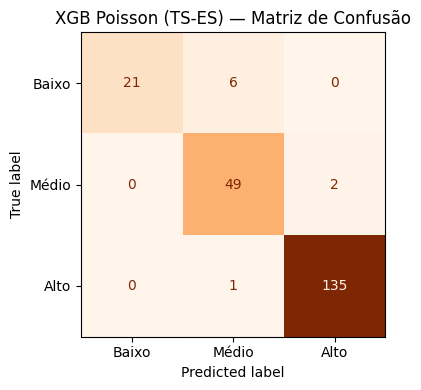


=== XGB Poisson (TS-ES) — Relatório de Classificação ===
              precision    recall  f1-score   support

       Baixo       1.00      0.78      0.88        27
       Médio       0.88      0.96      0.92        51
        Alto       0.99      0.99      0.99       136

    accuracy                           0.96       214
   macro avg       0.95      0.91      0.93       214
weighted avg       0.96      0.96      0.96       214


 MATRIZ DE CONFUSÃO - LSTM 
LSTM - treino: 6007  |  teste: 333

[ LSTM ] Faixas de risco (TREINO):
  Baixo : y <= 17.00
  Médio : 17.00 < y <= 44.00
  Alto  : y > 44.00

=== LSTM — Matriz de Confusão (Teste) ===
[[ 11  14   1]
 [  0  66   9]
 [  0  11 221]]


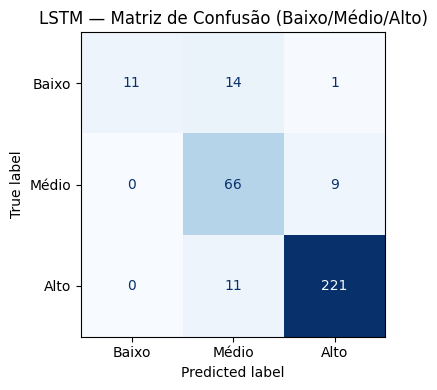


=== LSTM — Relatório de Classificação (Teste) ===
              precision    recall  f1-score   support

       Baixo       1.00      0.42      0.59        26
       Médio       0.73      0.88      0.80        75
        Alto       0.96      0.95      0.95       232

    accuracy                           0.89       333
   macro avg       0.89      0.75      0.78       333
weighted avg       0.91      0.89      0.89       333



In [49]:
# ============================================================
# MATRIZ DE CONFUSÃO — XGBoost Poisson (TS-ES) e LSTM
# (bloco independente para rodar após o pipeline)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# -------------------------
# 1) XGBoost Poisson (TS-ES)
# -------------------------

print("\n==============================")
print(" MATRIZ DE CONFUSÃO - XGBOOST ")
print("==============================")

# mesmo split temporal usado no treinar_modelos (val_weeks=26)
val_weeks = 26

ords = np.sort(np.unique(ord_vec))
if len(ords) > val_weeks:
    val_ords = ords[-val_weeks:]
else:
    val_ords = ords[-max(1, len(ords)//5):]

mask_val = np.isin(ord_vec, val_ords)
mask_tr  = ~mask_val

X_tr, y_tr = X[mask_tr], y[mask_tr]
X_val, y_val = X[mask_val], y[mask_val]

print(f"Tamanho treino: {X_tr.shape[0]}  |  validação: {X_val.shape[0]}")

# pega o modelo XGBoost Poisson treinado
modelo_xgb_p = modelos_treinados["XGBoost Poisson (TS-ES)"]
y_hat_val = modelo_xgb_p.predict(X_val)

# cria faixas de risco (Baixo/Médio/Alto) usando TERCIS do TREINO
q1, q2 = np.percentile(y_tr, [33.33, 66.67])

print("\n[ XGB Poisson (TS-ES) ] Faixas de risco (TREINO):")
print(f"  Baixo : y <= {q1:.2f}")
print(f"  Médio : {q1:.2f} < y <= {q2:.2f}")
print(f"  Alto  : y > {q2:.2f}")

def to_bucket(v, q1, q2):
    if v <= q1:
        return 0   # Baixo
    if v <= q2:
        return 1   # Médio
    return 2       # Alto

y_val_cls = np.array([to_bucket(v, q1, q2) for v in y_val])
y_hat_cls = np.array([to_bucket(v, q1, q2) for v in y_hat_val])

labels_txt = ["Baixo", "Médio", "Alto"]

cm_xgb = confusion_matrix(y_val_cls, y_hat_cls, labels=[0,1,2])
print("\n=== XGB Poisson (TS-ES) — Matriz de Confusão (Validação) ===")
print(cm_xgb)

fig, ax = plt.subplots(figsize=(5,4))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=labels_txt)
disp_xgb.plot(ax=ax, cmap="Oranges", colorbar=False)
ax.set_title("XGB Poisson (TS-ES) — Matriz de Confusão")
plt.tight_layout()
plt.show()

print("\n=== XGB Poisson (TS-ES) — Relatório de Classificação ===")
print(classification_report(y_val_cls, y_hat_cls, target_names=labels_txt))


# --------------
# 2) LSTM
# --------------

print("\n========================")
print(" MATRIZ DE CONFUSÃO - LSTM ")
print("========================")

# parâmetros usados na LSTM
lookback = 12
horizon = 1
cutoff_test = (2025, 1)

# reconstrói as sequências 3D igual ao treino da LSTM
df_seq = df_feat_sem_outliers.copy()
df_seq[features] = df_seq[features].ffill().bfill()
df_seq["casos"] = df_seq["casos"].astype(float)

X_all_lstm, y_all_lstm = _build_sequences_by_state(df_seq, features, lookback=lookback, horizon=horizon)
mask_train_lstm = _temporal_mask_by_cutoff(df_seq, lookback, horizon, cutoff=cutoff_test)

X_tr_lstm, y_tr_lstm = X_all_lstm[mask_train_lstm], y_all_lstm[mask_train_lstm]
X_te_lstm, y_te_lstm = X_all_lstm[~mask_train_lstm], y_all_lstm[~mask_train_lstm]

print(f"LSTM - treino: {X_tr_lstm.shape[0]}  |  teste: {X_te_lstm.shape[0]}")

# usa o mesmo scaler_lstm retornado pelo treinar_lstm_separado
n_features = X_tr_lstm.shape[-1]
X_tr_scaled_lstm = scaler_lstm.transform(X_tr_lstm.reshape(-1, n_features)).reshape(X_tr_lstm.shape)
X_te_scaled_lstm = scaler_lstm.transform(X_te_lstm.reshape(-1, n_features)).reshape(X_te_lstm.shape)

# previsões no teste
y_hat_te_lstm = model_lstm.predict(X_te_scaled_lstm, verbose=0).ravel()

# faixas de risco pelos tercis do TREINO LSTM
q1_l, q2_l = np.percentile(y_tr_lstm, [33.33, 66.67])
print("\n[ LSTM ] Faixas de risco (TREINO):")
print(f"  Baixo : y <= {q1_l:.2f}")
print(f"  Médio : {q1_l:.2f} < y <= {q2_l:.2f}")
print(f"  Alto  : y > {q2_l:.2f}")

def to_bucket_l(v):
    if v <= q1_l:
        return 0
    if v <= q2_l:
        return 1
    return 2

y_te_cls_l   = np.array([to_bucket_l(v) for v in y_te_lstm])
y_hat_cls_l  = np.array([to_bucket_l(v) for v in y_hat_te_lstm])

cm_lstm = confusion_matrix(y_te_cls_l, y_hat_cls_l, labels=[0,1,2])
print("\n=== LSTM — Matriz de Confusão (Teste) ===")
print(cm_lstm)

fig, ax = plt.subplots(figsize=(5,4))
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=labels_txt)
disp_lstm.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("LSTM — Matriz de Confusão (Baixo/Médio/Alto)")
plt.tight_layout()
plt.show()

print("\n=== LSTM — Relatório de Classificação (Teste) ===")
print(classification_report(y_te_cls_l, y_hat_cls_l, target_names=labels_txt))


In [50]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# ==========================
# 1. Função para categorizar casos
# ==========================
def categorizar(val):
    if val < q1: return 0   # Baixo
    elif val < q2: return 1 # Médio
    else: return 2          # Alto

# Recalcula Q1 e Q2 com base no y original
q1 = np.percentile(y, 33)
q2 = np.percentile(y, 66)

# ==========================
# 2. Tabela de métricas
# ==========================

linhas = []

media_y = float(np.mean(y)) if len(y) else np.nan

# Prepara vetor de classes reais (para acurácia)
y_cls = np.array([categorizar(v) for v in y])

# ==========================
# Modelos Clássicos
# ==========================
for nome, (mse, r2) in resultados.items():

    rmse = np.sqrt(mse)
    nrmse = (rmse / media_y * 100) if media_y != 0 else np.nan

    # Predição em todo o dataset
    y_pred = modelos_treinados[nome].predict(X)

    # Converte predições para classes
    y_pred_cls = np.array([categorizar(v) for v in y_pred])

    # Acurácia
    acc = accuracy_score(y_cls, y_pred_cls)

    linhas.append([nome, mse, rmse, r2, nrmse, acc])

# ==========================
# LSTM (se existir)
# ==========================
if "res_lstm" in globals():

    # pega métricas já calculadas
    for nome, (mse, rmse, r2, nrmse) in res_lstm.items():

        # Usa os vetores da classificação (já existentes)
        acc_lstm = accuracy_score(y_te_cls_l, y_hat_cls_l)

        linhas.append([nome, mse, rmse, r2, nrmse, acc_lstm])

# ==========================
# Monta tabela final
# ==========================
df_metricas = pd.DataFrame(
    linhas,
    columns=["Modelo", "MSE", "RMSE", "R2", "nRMSE (%)", "Acurácia"]
).sort_values("MSE").reset_index(drop=True)

# Exibe formatado
with pd.option_context("display.float_format", "{:,.4f}".format):
    print("=== Tabela de Métricas (Validação Temporal + Acurácia) ===")
    print(df_metricas.to_string(index=False))


=== Tabela de Métricas (Validação Temporal + Acurácia) ===
                 Modelo      MSE    RMSE     R2  nRMSE (%)  Acurácia
      Gradient Boosting  18.1395  4.2591 0.9856    10.8971    0.9644
XGBoost Poisson (TS-ES)  19.5454  4.4210 0.9845    11.3115    0.9829
                XGBoost  52.9570  7.2772 0.9581    18.6192    0.9436
          Random Forest 112.0370 10.5848 0.9113    27.0819    0.9131
                   LSTM 175.3438 13.2417 0.8591    19.5943    0.8949
